In [86]:
import numpy as np
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats import norm, expon, t, hypergeom, chi2
from scipy.signal import savgol_filter
import multiprocessing as mp
from scipy import mean, std
import matplotlib.pyplot as plt
import time

In [97]:
def choice(ps):
    return np.random.choice(len(ps), p=ps)

def prepend(h, it):
    for i in it:
        yield h, i

def take(li, k):
    return [i[k] for i in li]

def flatten(li):
    return [item for sublist in li for item in sublist]

def simulate_abtest(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])])
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations

def generalized_contingency_goodness_fit(observations, cell_fn):
    row_marginals = np.sum(observations, axis=1)
    col_marginals = np.sum(observations, axis=0)
    N = np.sum(observations)
    chisq = 0
    for i in range(len(row_marginals)):
        for j in range(len(col_marginals)):
            expected = row_marginals[i] * col_marginals[j] / N
            chisq += cell_fn(observations[i][j], expected)
    dof = (len(row_marginals) - 1) * (len(col_marginals) - 1)
    p_value = 1.0 - chi2(dof).cdf(chisq)
    return (chisq, p_value)

def generalized_chi_squared(observations):
    return generalized_contingency_goodness_fit(observations, lambda obs, exp: (obs - exp)**2 / exp)

def generalized_G(observations):
    return generalized_contingency_goodness_fit(observations, lambda obs, exp: 2 * obs * np.log(obs / exp))

def mp_map(mapfn, it, thread_count=None):
    if thread_count is None:
        thread_count = mp.cpu_count()
    pool = mp.Pool(thread_count)
    results = pool.map(mapfn, it)
    pool.close()
    return results

In [95]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
N = 1000

observations = simulate_abtest(funnels, N)
print(observations)
c_our = generalized_chi_squared(observations)
g_our = generalized_G(observations)
print('Chi-squared test statistic = %.3f' % c_our[0])
print('G test statistic = %.3f' % g_our[0])
print('Chi-squared p = %.6f' % c_our[1])
print('G p = %.6f'   % g_our[1])

[[247. 278.]
 [234. 241.]]
Chi-squared test statistic = 0.490
G test statistic = 0.490
Chi-squared p = 0.483775
G p = 0.483769


C:\Users\mtrencseni\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


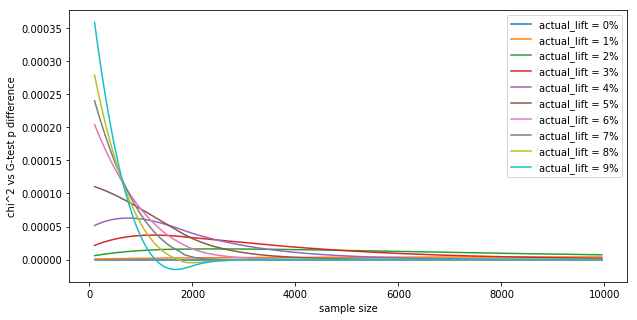

In [96]:
base_conversion = 0.5
traffic_split = 0.5

results = {}
for actual_lift in range(0, 10, 1):
    actual_lift /= 100.0
    results[actual_lift] = []
    for N in range(100, 10*1000, 50):
        observations = [
            [int(base_conversion * traffic_split * N), int((1-base_conversion) * traffic_split * N)],
            [int((base_conversion+actual_lift) * (1-traffic_split) * N), int((1-(base_conversion+actual_lift)) * (1-traffic_split) * N)],
        ]
        p_chi2 = generalized_chi_squared(observations)[1]
        p_g = generalized_G(observations)[1]
        p_diff = abs(p_chi2 - p_g)
        results[actual_lift].append((N, p_diff))

plt.figure(figsize=(10,5))
plt.xlabel('sample size')
plt.ylabel("""chi^2 vs G-test p difference""")
for actual_lift in results.keys():
    plt.plot([x[0] for x in results[actual_lift]], savgol_filter([x[1] for x in results[actual_lift]], 67, 3))
plt.legend(['actual_lift = %d%%' % (100*actual_lift) for actual_lift in results.keys()], loc='upper right')
plt.show()

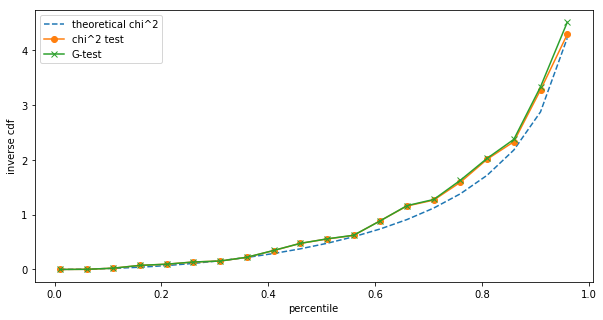

In [127]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
df = 1
N = 30
num_simulations = 1000

cs = []
gs = []
for _ in range(num_simulations):
    observations = simulate_abtest(funnels, N)
    cs.append(generalized_chi_squared(observations)[0])
    gs.append(generalized_G(observations)[0])

def percentiles(arr, ps):
    arr = sorted(arr)
    return [arr[int(x*len(arr))] for x in ps]
    
ps = [x/100.0 for x in range(1, 100, 5)]
expected_percentiles = [chi2.ppf(x, df) for x in ps]
c_percentiles = percentiles(cs, ps)
g_percentiles = percentiles(gs, ps)
plt.figure(figsize=(10,5))
plt.xlabel('percentile')
plt.ylabel('inverse cdf')
plt.plot(ps, chi2.ppf(ps, df), linestyle='--')
plt.plot(ps, c_percentiles, marker='o')
plt.plot(ps, g_percentiles, marker='x')
plt.legend(['theoretical chi^2', 'chi^2 test', 'G-test'], loc='upper left')
plt.show()

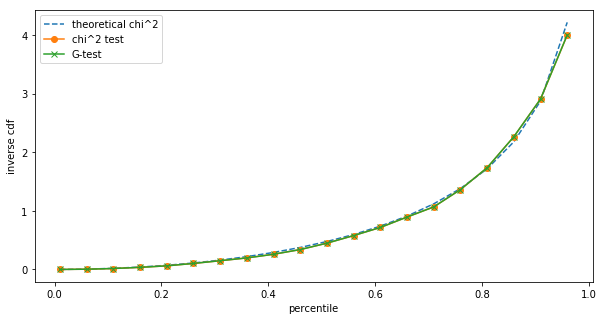

In [128]:
funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
df = 1
N = 1000
num_simulations = 1000

cs = []
gs = []
for _ in range(num_simulations):
    observations = simulate_abtest(funnels, N)
    cs.append(generalized_chi_squared(observations)[0])
    gs.append(generalized_G(observations)[0])

def percentiles(arr, ps):
    arr = sorted(arr)
    return [arr[int(x*len(arr))] for x in ps]
    
ps = [x/100.0 for x in range(1, 100, 5)]
expected_percentiles = [chi2.ppf(x, df) for x in ps]
c_percentiles = percentiles(cs, ps)
g_percentiles = percentiles(gs, ps)
plt.figure(figsize=(10,5))
plt.xlabel('percentile')
plt.ylabel('inverse cdf')
plt.plot(ps, chi2.ppf(ps, df), linestyle='--')
plt.plot(ps, c_percentiles, marker='o')
plt.plot(ps, g_percentiles, marker='x')
plt.legend(['theoretical chi^2', 'chi^2 test', 'G-test'], loc='upper left')
plt.show()

In [85]:
import gtest_worker

funnels = [
    [[0.50, 0.50], 0.5], # the first vector is the actual outcomes,
    [[0.50, 0.50], 0.5], # the second is the traffic split
]
df = 1
N = 100
num_simulations = 1000
num_fits_per_thread = 500
num_threads = 24

if __name__ ==  '__main__':
    for N in [50, 100, 1000]:
        print('Running simulations for with (N, num_simulations, num_fits_per_thread) = (%s, %s, %s) on %s threads' % ((N, num_simulations, num_fits_per_thread, num_threads)))
        start_time = time.time()
        results = mp_map(
            gtest_worker.mp_fit_chi2,
            [(num_fits_per_thread, num_simulations, funnels, N, df) for _ in range(num_threads)],
            num_threads)
        elapsed_time = time.time() - start_time
        print('Done! Elapsed %s' % time.strftime("%M:%S", time.gmtime(elapsed_time)))
        c_diffs = flatten([r[0] for r in results])
        g_diffs = flatten([r[1] for r in results])
        g_better_ratio = sum([(g_diff < c_diff) for c_diff, g_diff in zip(c_diffs, g_diffs)])/len(c_diffs)
        print('The G test statistic better approximates the theoretical Chi^2 distribution %.4f fraction of times out of %s fits' % (g_better_ratio, len(c_diffs)))
        print('-')

Running simulations for with (N, num_simulations, num_fits_per_thread) = (50, 1000, 500) on 24 threads
Done! Elapsed 29:45
The G test statistic better approximates the theoretical Chi^2 distribution 0.14 fraction of times out of 12000 fits
-
Running simulations for with (N, num_simulations, num_fits_per_thread) = (100, 1000, 500) on 24 threads
Done! Elapsed 46:45
The G test statistic better approximates the theoretical Chi^2 distribution 0.56 fraction of times out of 12000 fits
-
Running simulations for with (N, num_simulations, num_fits_per_thread) = (1000, 1000, 500) on 24 threads
Done! Elapsed 52:06
The G test statistic better approximates the theoretical Chi^2 distribution 0.48 fraction of times out of 12000 fits
-


In [ ]:
# gtest_worker.py

import numpy as np
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats import norm, expon, t, hypergeom, chi2
from scipy.signal import savgol_filter
from scipy import mean, std

def percentile_diff(arr, percentiles, expected_percentiles):
    arr = sorted(arr)
    a_percentiles = [arr[int(x*len(arr))] for x in percentiles]
    a_diff = sum([abs(a - e) for a, e in zip(a_percentiles, expected_percentiles)])/len(expected_percentiles)
    return a_diff
    
def mp_fit_chi2(args):
    (num_fits, num_simulations, funnels, N, df) = args
    percentiles = [x/10.0 for x in range(1, 10, 1)]
    expected_percentiles = [chi2.ppf(x, df) for x in percentiles]
    c_diffs = []
    g_diffs = []
    for i in range(num_fits):
        cs = []
        gs = []
        for _ in range(num_simulations):
            observations = simulate_abtest(funnels, N)
            cs.append(generalized_chi_squared(observations)[0])
            gs.append(generalized_G(observations)[0])
        c_diffs.append(percentile_diff(cs, percentiles, expected_percentiles))
        g_diffs.append(percentile_diff(gs, percentiles, expected_percentiles))
    return c_diffs, g_diffs

def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])])
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations

def generalized_contingency_goodness_fit(observations, cell_fn):
    row_marginals = np.sum(observations, axis=1)
    col_marginals = np.sum(observations, axis=0)
    N = np.sum(observations)
    chisq = 0
    for i in range(len(row_marginals)):
        for j in range(len(col_marginals)):
            expected = row_marginals[i] * col_marginals[j] / N
            chisq += cell_fn(observations[i][j], expected)
    dof = (len(row_marginals) - 1) * (len(col_marginals) - 1)
    p_value = 1.0 - chi2(dof).cdf(chisq)
    return (chisq, p_value)

def generalized_chi_squared(observations):
    return generalized_contingency_goodness_fit(observations, lambda obs, exp: (obs - exp)**2 / exp)

def generalized_G(observations):
    return generalized_contingency_goodness_fit(observations, lambda obs, exp: 2 * obs * np.log(obs / exp))